# Implement a convolutional neural network to recognize hand-written digits

In [ ]:
# Uncomment the below line and run to install required packages if you have not done so

# !pip install torch torchvision matplotlib tqdm

In [1]:
# Setup
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from tqdm import trange

%matplotlib inline
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
seed = 1234
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

## Get MNIST Data
The `torchvision` package provides a wrapper to download MNIST data. The cell below downloads the training and test datasets and creates dataloaders for each.

In [2]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

## Use the following lines to check the basic statistics of this dataset
# Calculate training data mean and standard deviation to apply normalization to data
# train_data.data are of type uint8 (range 0,255) so divide by 255.
train_mean = train_data.data.double().mean() / 255.
train_std = train_data.data.double().std() / 255.
print(f'Train Data: Mean={train_mean}, Std={train_std}')

## Optional: Perform normalization of train and test data using calculated training mean and standard deviation
# This will convert data to be approximately standard normal
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((train_mean, ), (train_std, ))
])

train_data.transform = transform
test_data.transform = transform

batch_size = 64
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 119553228.66it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27726183.07it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24410952.62it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18787503.72it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Train Data: Mean=0.1306604762738429, Std=0.30810780717887876


## Part 0: Inspect dataset

Images shape:  torch.Size([64, 1, 28, 28])
Labels shape:  torch.Size([64])
Mean=0.00834457017481327, Std=1.0060752630233765


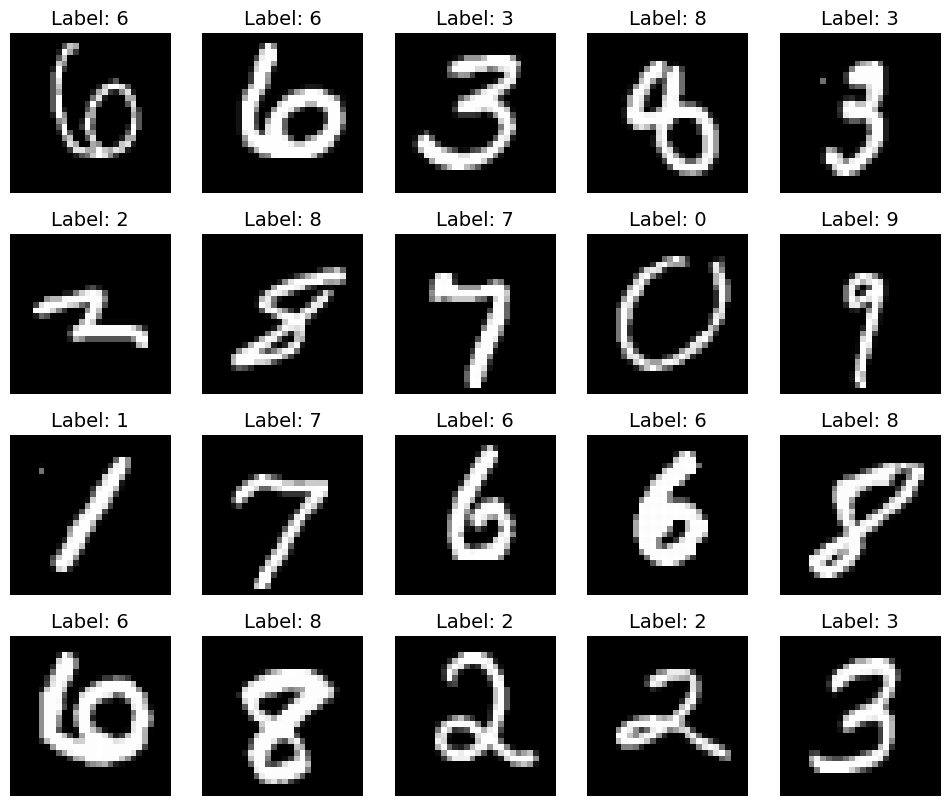

In [3]:
# Randomly sample 20 images of the training dataset
# To visualize the i-th sample, use the following code
# > plt.subplot(4, 5, i+1)
# > plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
# > plt.title(f'Label: {labels[i]}', fontsize=14)
# > plt.axis('off')

images, labels = next(iter(train_loader))

# Print information and statistics of the first batch of images
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)
print(f'Mean={images.mean()}, Std={images.std()}')

fig = plt.figure(figsize=(12, 10))

# ------------------
# Copy the implementation from Problem 4 here
rand_idxs = np.random.choice(len(images), 20, replace=False)
for i, idx in enumerate(rand_idxs):
  plt.subplot(4, 5, i+1)
  plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
  plt.title(f'Label: {labels[i]}', fontsize=14)
  plt.axis('off')

# ------------------

## Part 1: Implement a convolutional neural network

Write a class that constructs a two-layer neural network as specified in the handout. The class consists of two methods, an initialization that sets up the architecture of the model, and a forward pass function given an input feature.

In [12]:
input_size = 1 * 28 * 28  # input spatial dimension of images
hidden_size = 128         # width of hidden layer
output_size = 10          # number of output neurons

class CNN(torch.nn.Module):

    def __init__(self):

        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        # ------------------
        # Write your implementation here.
        self.conv1 = torch.nn.Conv2d(1, 10, stride=1, kernel_size=5) # first convolutional layer
        self.maxpool1 = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(10, 20, stride=1, kernel_size=5) # second convolutional layer
        self.maxpool2 = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(4 * 4 * 20, output_size) # third fully-connected layer
        # ------------------

    def forward(self, x):
        # Input image is of shape [batch_size, 1, 28, 28]
        # Need to flatten to [batch_size, 784] before feeding to fc1

        # ------------------
        # Write your implementation here.
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = torch.nn.functional.log_softmax(x)
        y_output = x

        return y_output
        # ------------------

model = CNN().to(DEVICE)

# sanity check
print(model)

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=320, out_features=10, bias=True)
)


Write a method called `train_one_epoch` that runs one step using the optimizer.

In [13]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    criterion = torch.nn.NLLLoss()
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)

        # ------------------
        # Copy the implementation from Problem 4 here
        optimizer.zero_grad()
        output = model(img)
        best_pred = torch.argmax(output, dim=1)


        loss = criterion(output, label)

        loss.backward()
        optimizer.step()
        # ------------------

        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter

Write a method called `test_one_epoch` that evalutes the trained model on the test dataset. Return the average test loss and the number of samples that the model predicts correctly.

In [14]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    criterion = torch.nn.NLLLoss()
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            # ------------------
            # Copy the implementation from Problem 4 here

            output = model(img)
            pred = torch.argmax(output, dim=1) # Get index of largest log-probability and use that as prediction
            num_correct += (pred == label).sum().item()
            loss = criterion(output, label)
            test_loss += loss.item()

            # ------------------

    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

Train the model using the cell below. Hyperparameters are given.

In [15]:
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_counter = []
test_losses = []
test_correct = []
for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    test_correct.append(num_correct)

print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-12-ae7edf7a33a7>:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.functional.log_softmax(x)
Epochs: 100%|██████████| 10/10 [03:21<00:00, 20.14s/it]

Test accuracy: 0.9863


In [16]:
train_loss, train_accuracy = test_one_epoch(train_loader, model, DEVICE)
test_loss, test_accuracy = test_one_epoch(test_loader, model, DEVICE)

print(f"Training Data: Loss = {train_loss}, Accuracy = {(train_accuracy/len(train_loader.dataset)) * 100}%")
print(f"Test Data: Loss = {test_loss}, Accuracy = {(test_accuracy/len(test_loader.dataset)) * 100}%")

<ipython-input-12-ae7edf7a33a7>:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.functional.log_softmax(x)


Training Data: Loss = 0.000719262181581386, Accuracy = 98.63%
Test Data: Loss = 0.0007134093719752855, Accuracy = 98.63%


In [17]:
from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
         MaxPool2d-2           [-1, 10, 12, 12]               0
            Conv2d-3             [-1, 20, 8, 8]           5,020
         MaxPool2d-4             [-1, 20, 4, 4]               0
           Flatten-5                  [-1, 320]               0
            Linear-6                   [-1, 10]           3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.03
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


<ipython-input-12-ae7edf7a33a7>:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.functional.log_softmax(x)
